In [1]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import time
from datetime import timedelta
import h5py
from tqdm import tqdm
import argparse
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

import sys

import sys
import os
import json
import h5py
import numpy as np
import wfdb
from tqdm import tqdm

server = "newton"
server_config_path = os.path.join("/home/liranc6/ecg_forecasting/liran_project/utils/server_config.json")
# set server configuration
with open(server_config_path) as f:
    server_config = json.load(f)
    server_config = server_config[server]
    project_path = server_config['project_path']
    data_path = server_config['data_preprocess']['data_path']
    raw_data_dir = server_config['data_preprocess']['raw_data_dir']
    
sys.path.append(project_path)

if server == "rambo":
    os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
    os.environ['CUDA_VISIBLE_DEVICES'] = '6'

import liran_project.utils.dataset_loader as dataset_loader

# import liran_project.train as liran_train
from liran_project.utils.dataset_loader import SingleLeadECGDatasetCrops
from liran_project.utils.util import modify_z_and_omega

from SSSD_main.src.utils.util import find_epoch, print_size, sampling, calc_diffusion_hyperparams
from SSSD_main.src.utils.util import get_mask_mnr, get_mask_bm, get_mask_rm, get_mask_pred

import SSSD_main.src.utils.util as util
from SSSD_main.src.imputers.DiffWaveImputer import DiffWaveImputer
from SSSD_main.src.imputers.SSSDSAImputer import SSSDSAImputer
from SSSD_main.src.imputers.SSSDS4Imputer import SSSDS4Imputer

ImportError: cannot import name 'SingleLeadECGDatasetCrops' from 'liran_project.utils.dataset_loader' (/home/liranc6/ecg_forecasting/liran_project/utils/dataset_loader.py)

In [92]:
import torch

# Example tensor with shape [batch_size, sequence_length, num_features]
x = torch.randn(2, 4, 1)  # [8, 10, 5]

print(x.shape)
print(x)

# Slicing x[:, -1, :]
result = x[:, -1, :].unsqueeze(1)

print(result.shape)  # Output: torch.Size([8, 5])
print(result)

torch.Size([2, 4, 1])
tensor([[[-1.6572],
         [ 0.0504],
         [-0.5173],
         [ 0.6825]],

        [[ 1.7907],
         [-0.3429],
         [-1.1115],
         [-0.2587]]])
torch.Size([2, 1, 1])
tensor([[[ 0.6825]],

        [[-0.2587]]])


In [13]:
#cwd
os.getcwd()

'/home/liranc6/ecg_forecasting/liran_project/notebooks'

In [4]:
import os

def create_tree(directory, indent=""):
    print(indent + os.path.basename(directory) + "/")
    
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            create_tree(item_path, indent + "  ")
        else:
            print(indent + "  " + item)

# Replace 'your_directory_path' with the path of the directory you want to create a tree for.
directory_path = '/home/liranc6/ecg/ecg_forecasting/data/icentia11k-continuous-ecg/'

if os.path.exists(directory_path):
    create_tree(directory_path)
else:
    print(f"The directory '{directory_path}' does not exist.")

/
  ANNOTATORS
  index.html
  LICENSE.txt
  p00/
    index.html
    p00000/
      index.html
      RECORDS
      p00000_s00.atr
      p00000_s00.dat
      p00000_s00.hea
      p00000_s01.atr
      p00000_s01.dat
      p00000_s01.hea
      p00000_s02.atr
      p00000_s02.dat
      p00000_s02.hea
      p00000_s03.atr
      p00000_s03.dat
      p00000_s03.hea
      p00000_s04.atr
      p00000_s04.dat
      p00000_s04.hea
      p00000_s05.atr
      p00000_s05.dat
      p00000_s05.hea
      p00000_s06.atr
      p00000_s06.dat
      p00000_s06.hea
      p00000_s07.atr
      p00000_s07.dat
      p00000_s07.hea
      p00000_s08.atr
      p00000_s08.dat
      p00000_s08.hea
      p00000_s09.atr
      p00000_s09.dat
      p00000_s09.hea
      p00000_s10.atr
      p00000_s10.dat
      p00000_s10.hea
      p00000_s11.atr
      p00000_s11.dat
      p00000_s11.hea
      p00000_s12.atr
      p00000_s12.dat
      p00000_s12.hea
      p00000_s13.atr
      p00000_s13.dat
      p00000_s13.hea
      p0000

In [3]:
import numpy as np

# assuming signals and indices are defined
signals = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
indices = np.array([1, 3, 5, 7])

beats = np.zeros(signals.shape[0])
beats[indices] = 1

# stack signals and beats into a 2D array
result = np.vstack((signals, beats))

result

array([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 0.]])

In [5]:
result = np.concatenate((signals, beats), axis=1)
result

AxisError: axis 1 is out of bounds for array of dimension 1

In [1]:
import h5py
import numpy as np

def open_h5_file_and_show_first_sample(file_path):
    with h5py.File(file_path, 'r') as h5_file:
        keys = sorted(h5_file.keys())
        group_keys = sorted(h5_file.keys())
        print(f"Keys: {keys}")
        print(f"Group keys: {group_keys}")
        
        for key in keys:
            print(f"Key: {key}")
            print(f"Shape: {h5_file[key].shape}")
            print(f"Value: {h5_file[key][0]}")
            break
    
    


# file_path = "/mnt/qnap/liranc6/data/with_R_beats/icentia11k-continuous-ecg_normal_sinus_subset_npArrays_splits/10minutes_window.h5"
# file_path = "/mnt/qnap/liranc6/data/with_R_beats/icentia11k-continuous-ecg_normal_sinus_subset_npArrays.h5"
file_path = '/mnt/qnap/liranc6/data/with_R_beats/icentia11k-continuous-ecg_normal_sinus_subset_npArrays_splits/10minutes_window_temp.h5'
open_h5_file_and_show_first_sample(file_path)

Keys: ['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008']
Group keys: ['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008']
Key: 00000
Shape: (0,)


IndexError: Index (0) out of range for empty dimension

In [7]:
import os
import sys
sys.path.append("/home/liranc6/ecg/ecg_forecasting/liran_project/utils")
import data_preparation
# data_preparation.print_h5_hierarchy(file_path)
# print first dataset
def print_dataset(file_path):
    with h5py.File(file_path, 'r') as h5_file:
        keys = sorted(h5_file.keys())
        for key in keys:
            print(f"Key: {key}")
            print(f"Shape: {h5_file[key].shape}")
            print(f"Value: {h5_file[key][0]}")
            break

# print_dataset(file_path)
data_preparation.count_items(file_path)

Dataset: /00000, Count: 0
Dataset: /00001, Count: 0
Dataset: /00002, Count: 0
Dataset: /00003, Count: 0
Dataset: /00004, Count: 0
Dataset: /00005, Count: 0
Dataset: /00006, Count: 0
Dataset: /00007, Count: 0
Dataset: /00008, Count: 0
Total count: 0


In [12]:
import numpy as np
#create array with shape [1, 2, 10]
a = np.random.rand(2, 10)
print(f"{a=}")

window_size = 5
num_windows = a.shape[1] // window_size
print(f"{num_windows=}")
# Split the array into smaller arrays of window_size along the second axis
result = [a[:, i:i + window_size] for i in range(0, a.shape[1], window_size)]

# Convert the result to an array of subarrays
result = np.array(result)

# Print the result
print(result)

a=array([[0.75561255, 0.3418389 , 0.32594068, 0.64460466, 0.597923  ,
        0.87878053, 0.24768316, 0.53570814, 0.30807981, 0.16774639],
       [0.79225451, 0.38278559, 0.76761923, 0.5211686 , 0.80412334,
        0.64473882, 0.33466251, 0.44096894, 0.22946018, 0.88897458]])
num_windows=2
[[[0.75561255 0.3418389  0.32594068 0.64460466 0.597923  ]
  [0.79225451 0.38278559 0.76761923 0.5211686  0.80412334]]

 [[0.87878053 0.24768316 0.53570814 0.30807981 0.16774639]
  [0.64473882 0.33466251 0.44096894 0.22946018 0.88897458]]]


In [2]:
def mse_distance_batch(y_batch, y_pred_batch):
    
    total_error = F.mse_loss(y_batch.float(), y_pred_batch.float()).item()

    return total_error

In [4]:
import torch
import torch.nn.functional as F

# Example data
pred = torch.tensor([2.5, 0.0, 2.0, 8.0])
target = torch.tensor([3.0, -0.5, 2.0, 7.0])

# Calculate MSE
def mse(pred, target):
    return F.mse_loss(pred, target)

# Calculate RMSE
def rmse(pred, target):
    return torch.sqrt(mse(pred, target))

# Calculate MAE
def mae(pred, target):
    return F.l1_loss(pred, target)

mse, rmse, mae = mse(pred, target), rmse(pred, target), mae(pred, target)
print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

mse_distance_batch(pred, target)

MSE: 0.38, RMSE: 0.61, MAE: 0.50


0.375

In [10]:
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

a = [[1, 4, 3, 2, 4, 2, 4], [1, 4, 3, 2, 4]]
b = [[5, 3, 4, 6, 4, 5, 7], [5, 3, 4, 6, 4]]

# Convert lists to tensors and pad
a = pad_sequence([torch.tensor(x) for x in a], batch_first=True)
b = pad_sequence([torch.tensor(x) for x in b], batch_first=True)

mae = F.l1_loss(a.float(), b.float()).item()
mae

1.8571428060531616

In [8]:
filename = "ywwhgg9f_best_model:_iter:_10.pth"
parts = filename.split('_')
iter_number_part = parts[4]
iter_number = int(iter_number_part.split('.')[0])  # Split by '.' and convert the first part to an integer
print(iter_number)

10


In [11]:
# Import necessary functions
from liran_project.utils.util import differences_by_R_indices, chamfer_distance_batch, prune_to_same_length, align_indices, mae_distance_batch

# Define two lists of indices to represent the locations of R-peaks in two ECG signals
ecg_R_beats_batch_indices = [torch.tensor([10, 22, 30, 40, 50, 200, 490]).int()]
ecg_pred_R_beats_batch_indices = [torch.tensor([12, 20, 32, 42, 500]).int()]

# Define the length of the ECG signals
ecg_len = 600

# mae = F.l1_loss(torch.tensor(ecg_R_beats_batch_indices[0]).float(), torch.tensor(ecg_pred_R_beats_batch_indices[0]).float()).item()
# print(mae)
# Use the differences_by_R_indices function to compute the differences between the two lists of indices
diffs = differences_by_R_indices(ecg_R_beats_batch_indices, ecg_pred_R_beats_batch_indices, ecg_len)

# Print the computed differences
print(diffs)

TypeError: only integer tensors of a single element can be converted to an index

In [2]:
def t_uniform_sampling(T, B):
    return torch.randint(T, size=(B, 1, 1)).cuda()

def t_importance_sampling(T, loss_per_step, B):
    # Normalize the loss to get a probability distribution
    probabilities = loss_per_step / loss_per_step.sum()
    return torch.multinomial(probabilities, num_samples=B, replacement=True).view(B, 1, 1).cuda()

def t_curriculum_learning(T, current_epoch, total_epochs, B):
    # Start with easier (later) steps and introduce earlier (harder) steps as training progresses
    start_t = int((current_epoch / total_epochs) * T)
    return torch.randint(low=start_t, high=T, size=(B, 1, 1)).cuda()

def t_prioritized_sampling(T, loss_per_step, B):
    # Higher loss values have higher probability
    probabilities = loss_per_step / loss_per_step.sum()
    return torch.multinomial(probabilities, num_samples=B, replacement=True).view(B, 1, 1).cuda()

def t_adaptive_sampling(T, model_performance, B):
    # Adjust sampling based on model's performance
    difficulties = 1 / (model_performance + 1e-6)  # Avoid division by zero
    probabilities = difficulties / difficulties.sum()
    return torch.multinomial(probabilities, num_samples=B, replacement=True).view(B, 1, 1).cuda()


def t_scheduled_sampling(T, current_epoch, schedule, B):
    # schedule is a list of (epoch_range, (start, end)) tuples
    for epoch_range, t_range in schedule:
        if epoch_range[0] <= current_epoch <= epoch_range[1]:
            return torch.randint(low=t_range[0], high=t_range[1], size=(B, 1, 1)).cuda()
    return torch.randint(T, size=(B, 1, 1)).cuda()

def t_gaussian_sampling(T, mean, std, B):
    # Sample from a Gaussian distribution and clip the values to be within [0, T)
    samples = torch.normal(mean, std, size=(B,)).clamp(0, T-1).long().view(B, 1, 1).cuda()
    return samples

def t_beta_sampling(T, alpha, beta, B):
    # Sample from a Beta distribution, scale to [0, T)
    samples = torch.distributions.Beta(alpha, beta).sample((B,)) * (T-1)
    samples = samples.clamp(0, T-1).long().view(B, 1, 1).cuda()
    return samples

def t_half_cauchy_sampling(T, scale, B):
    # Sample from a Half-Cauchy distribution
    samples = torch.distributions.HalfCauchy(scale).sample((B,))
    samples = samples.clamp(0, T-1).long().view(B, 1, 1).cuda()
    return samples

def t_sampling_strategy(sampling_strategy, T, B, loss_per_step=None, current_epoch=None, total_epochs=None, schedule=None, model_performance=None, mean=None, std=None, alpha=None, beta=None, scale=None):
        # Sample diffusion steps based on the chosen strategy
    if sampling_strategy == "uniform":
        diffusion_steps = t_uniform_sampling(T, B)
    elif sampling_strategy == "importance":
        diffusion_steps = t_importance_sampling(T, loss_per_step, B)
    elif sampling_strategy == "curriculum":
        diffusion_steps = t_curriculum_learning(T, current_epoch, total_epochs, B)
    elif sampling_strategy == "prioritized":
        diffusion_steps = t_prioritized_sampling(T, loss_per_step, B)
    elif sampling_strategy == "scheduled":
        diffusion_steps = t_scheduled_sampling(T, current_epoch, schedule, B)
    elif sampling_strategy == "adaptive":
        diffusion_steps = t_adaptive_sampling(T, model_performance, B)
    elif sampling_strategy == "gaussian":
        diffusion_steps = t_gaussian_sampling(T, mean, std, B)
    elif sampling_strategy == "beta":
        diffusion_steps = t_beta_sampling(T, alpha, beta, B)
    elif sampling_strategy == "half_cauchy":
        diffusion_steps = t_half_cauchy_sampling(T, scale, B)
    else:
        raise ValueError(f"Unknown sampling strategy: {sampling_strategy}")

    return diffusion_steps

In [5]:
# Define some necessary variables
T = 100
B = 10
loss_per_step = torch.rand(T)
current_epoch = 5
total_epochs = 20
schedule = [((0, 10), (0, 50)), ((11, 20), (51, 100))]
model_performance = torch.rand(B)
mean = 50
std = 10
alpha = 2
beta = 5
scale = 1

# Test uniform sampling
print(t_sampling_strategy("uniform", T, B).view(-1).tolist())

# Test importance sampling
print(t_sampling_strategy("importance", T, B, loss_per_step=loss_per_step).view(-1).tolist())

# Test curriculum learning
print(t_sampling_strategy("curriculum", T, B, current_epoch=current_epoch, total_epochs=total_epochs).view(-1).tolist())

# Test prioritized sampling
print(t_sampling_strategy("prioritized", T, B, loss_per_step=loss_per_step).view(-1).tolist())

# Test scheduled sampling
print(t_sampling_strategy("scheduled", T, B, current_epoch=current_epoch, schedule=schedule).view(-1).tolist())

# Test adaptive sampling
print(t_sampling_strategy("adaptive", T, B, model_performance=model_performance).view(-1).tolist())

# Test gaussian sampling
print(t_sampling_strategy("gaussian", T, B, mean=mean, std=std).view(-1).tolist())

# Test beta sampling
print(t_sampling_strategy("beta", T, B, alpha=alpha, beta=beta).view(-1).tolist())

# Test half cauchy sampling
print(t_sampling_strategy("half_cauchy", T, B, scale=scale).view(-1).tolist())

[94, 83, 67, 77, 3, 54, 72, 16, 44, 57]
[81, 55, 63, 15, 87, 11, 43, 95, 44, 26]
[48, 53, 77, 35, 33, 79, 58, 59, 69, 61]
[26, 28, 69, 67, 52, 18, 69, 24, 73, 58]
[20, 33, 20, 3, 46, 10, 42, 36, 19, 38]
[5, 2, 2, 2, 2, 2, 2, 7, 2, 0]
[43, 50, 35, 78, 52, 60, 67, 56, 31, 55]
[12, 32, 36, 3, 30, 61, 72, 56, 23, 27]
[5, 0, 0, 2, 1, 0, 15, 0, 1, 0]


In [15]:
import wandb

# Initialize a new run
run = wandb.init(project="my_project", name="scatter_demo")

# Some example data
x = [1, 2, 3, 4, 5]
y = [8, 7, 4, 11, 6]

# Initialize a table
table = wandb.Table(columns=["x", "y"])

# Log the data
for i in range(len(x)):
    wandb.log({"x": x[i], "y": y[i]})
    table.add_data(3, y[i])

# Log the table
wandb.log({"xy_table": table})

# Finish the run
run.finish()

10.219206025173488

Length of list at key "stage": 3808
Length of list at key "table_idx": 0
Length of list at key "Iteration": 3808
Length of list at key "batch_num": 0
Length of list at key "loss_per_t": 3808
Length of list at key "diffusion_steps_t": 3808


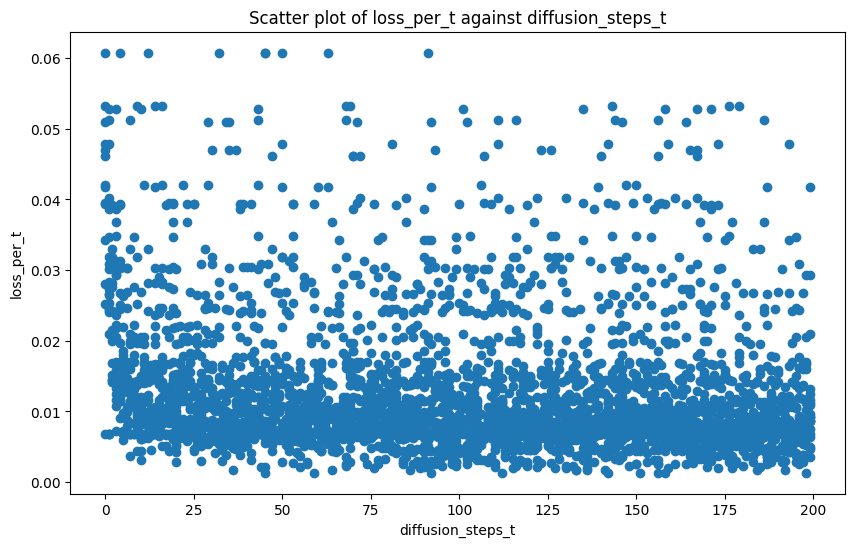

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import json

filename = \
"/home/liranc6/ecg_forecasting/liran_project/results/icentia11k/SSSDS4/context5000_label5000/T200_beta000001_betaT002/17_59_06_07_24_ywwhgg9f/track_t_data_table.json"
# "/home/liranc6/ecg_forecasting/liran_project/results/icentia11k/SSSDS4/context5000_label5000/T200_beta000001_betaT002/13_24_09_07_24_a6blw72n/track_t_data_table_144.json"
# "/home/liranc6/ecg_forecasting/liran_project/results/icentia11k/SSSDS4/context5000_label5000/T200_beta000001_betaT002/13_24_09_07_24_a6blw72n/track_t_data_table_1.json"

#open track_t_data_table from a file
with open(filename, 'r') as f:
    track_t_data_table = json.load(f)

# Print the lengths of the lists in the dictionary
for key, value in track_t_data_table.items():
    print(f'Length of list at key "{key}": {len(value)}')

# Remove keys with lists of size 0
track_t_data_table = {k: v for k, v in track_t_data_table.items() if len(v) != 0}

# Convert dictionary to DataFrame
df = pd.DataFrame(track_t_data_table)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['diffusion_steps_t'], df['loss_per_t'])
plt.xlabel('diffusion_steps_t')
plt.ylabel('loss_per_t')
plt.title('Scatter plot of loss_per_t against diffusion_steps_t')
plt.show()

In [10]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,5)  # Set default figure size

<Figure size 3000x600 with 0 Axes>

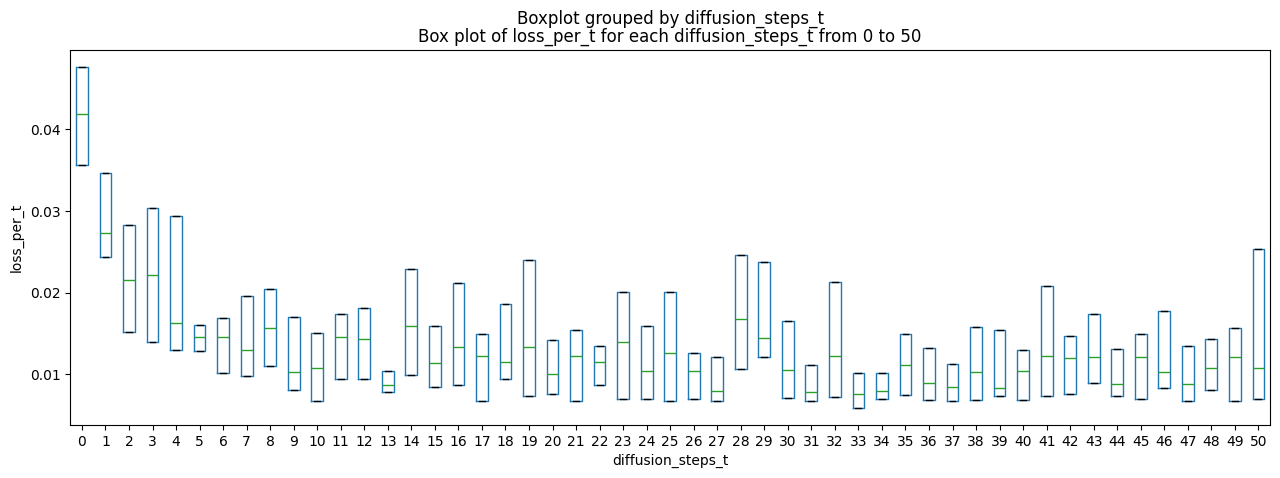

<Figure size 3000x600 with 0 Axes>

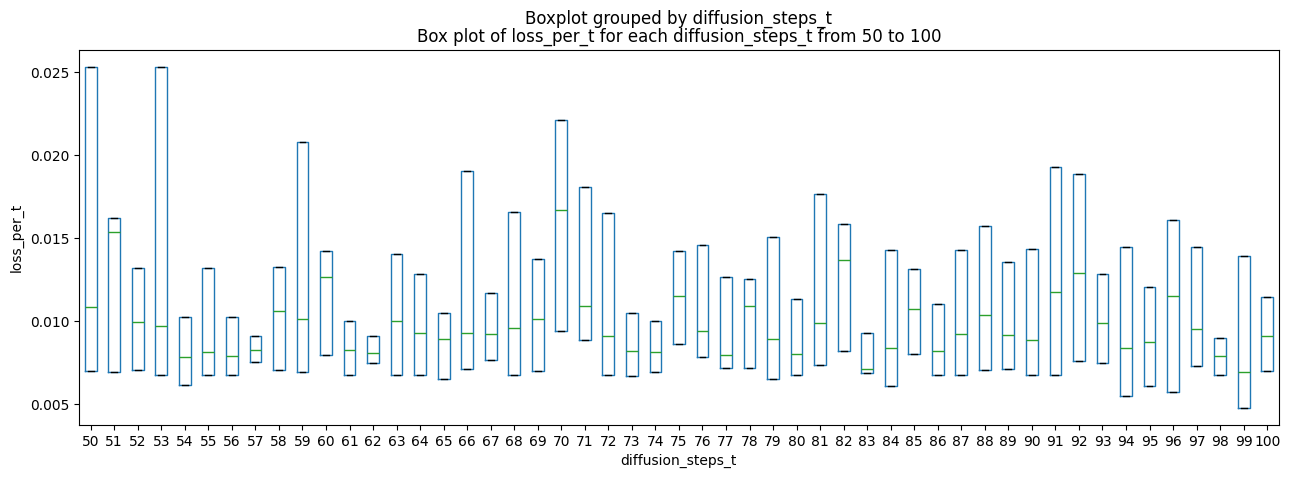

<Figure size 3000x600 with 0 Axes>

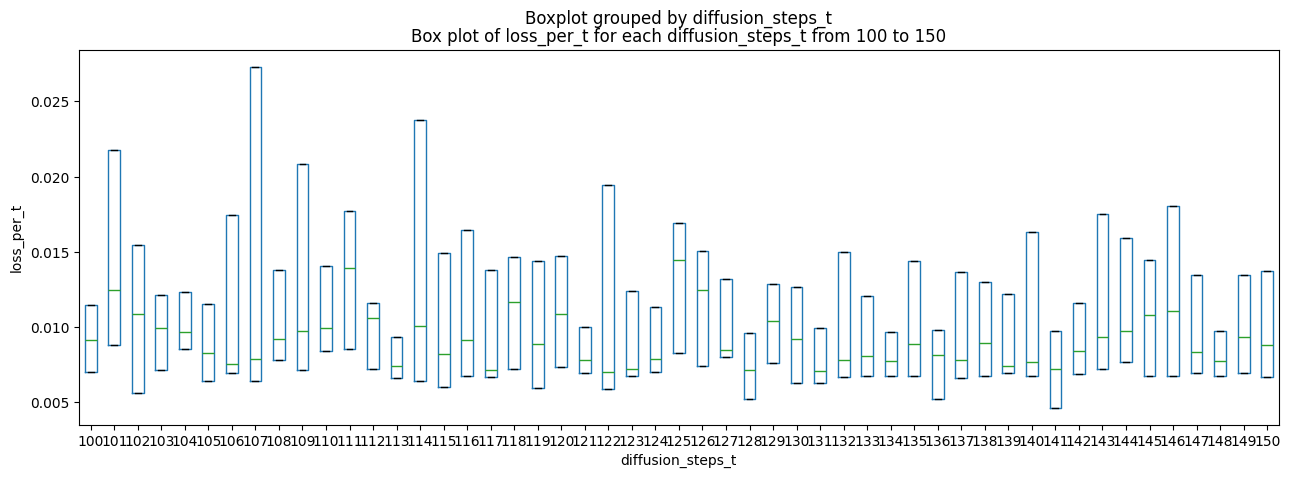

<Figure size 3000x600 with 0 Axes>

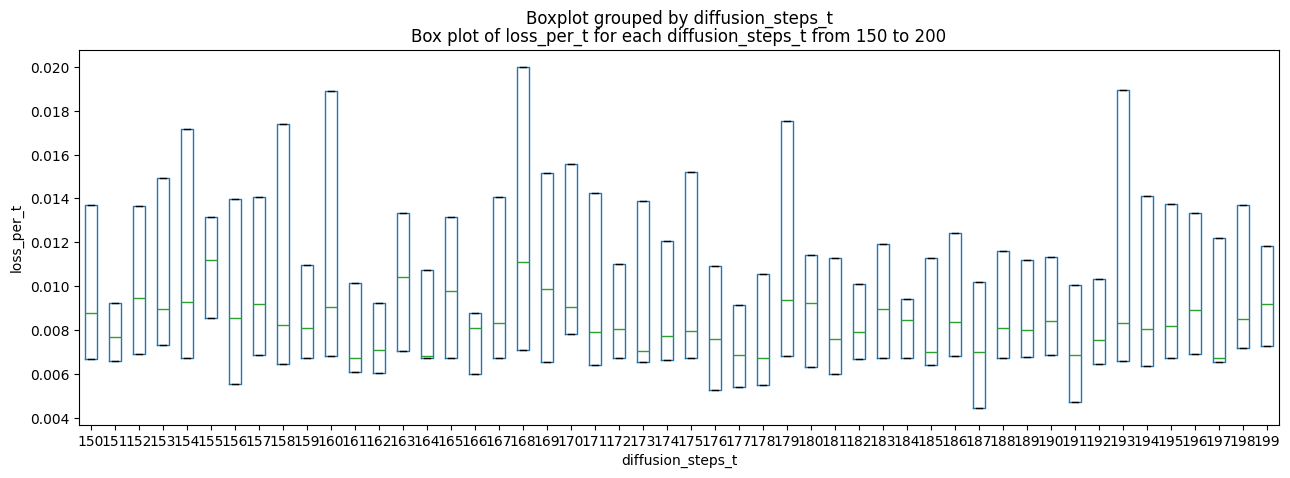

<Figure size 3000x600 with 0 Axes>

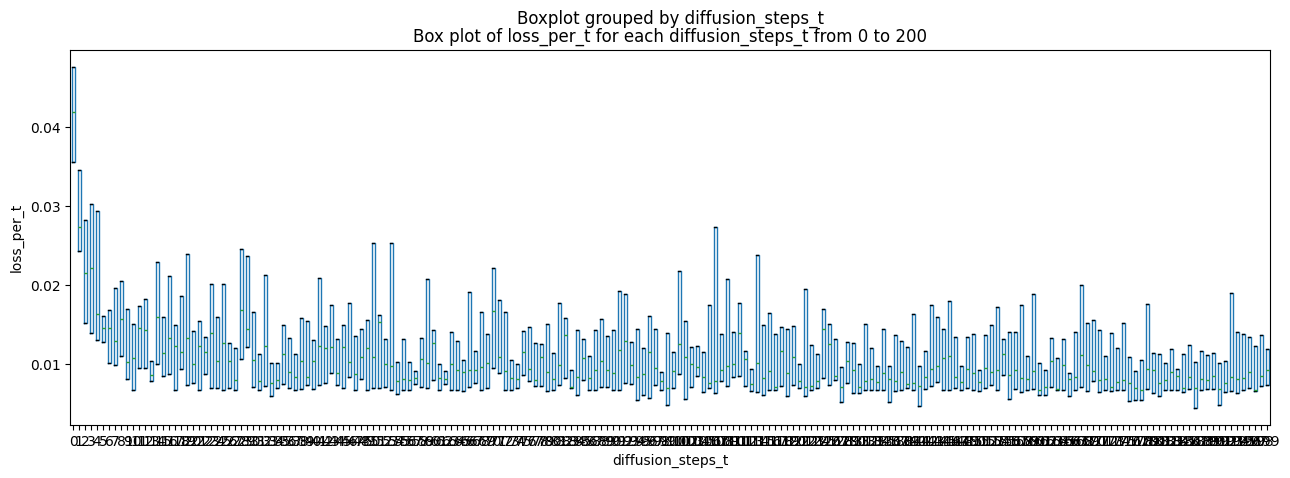

In [11]:
# Define the ranges
ranges = [(0, 50), (50, 100), (100, 150), (150, 200), (0, 200)]

# Create a box plot for each range
for start, end in ranges:
    df_filtered = df[df['diffusion_steps_t'].between(start, end)]
    plt.figure(figsize=(30, 6))  # Increase the width to 15
    df_filtered.boxplot(column='loss_per_t', by='diffusion_steps_t', whis=0, showfliers=False)
    plt.xlabel('diffusion_steps_t')
    plt.ylabel('loss_per_t')
    plt.title(f'Box plot of loss_per_t for each diffusion_steps_t from {start} to {end}')
    plt.grid(False)
    plt.show()

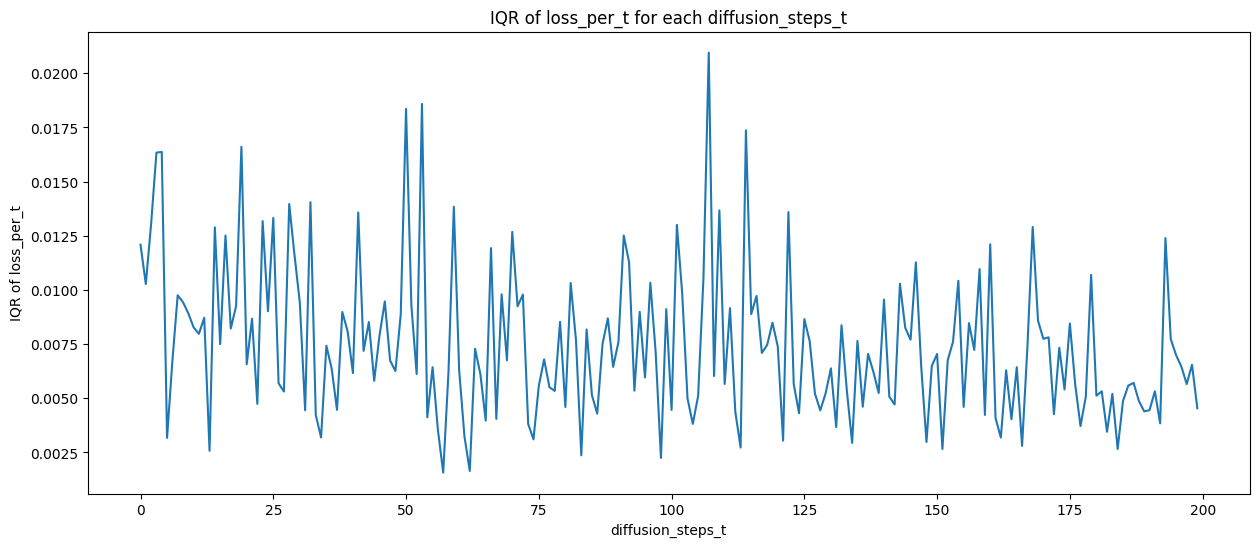

In [12]:
# Calculate the IQR for each diffusion_steps_t
df['IQR'] = df.groupby('diffusion_steps_t')['loss_per_t'].apply(lambda x: x.quantile(0.75) - x.quantile(0.25))

# Plot the IQR by diffusion_steps_t
plt.figure(figsize=(15, 6))
df['IQR'].plot(kind='line')
plt.xlabel('diffusion_steps_t')
plt.ylabel('IQR of loss_per_t')
plt.title('IQR of loss_per_t for each diffusion_steps_t')
plt.grid(False)
plt.show()

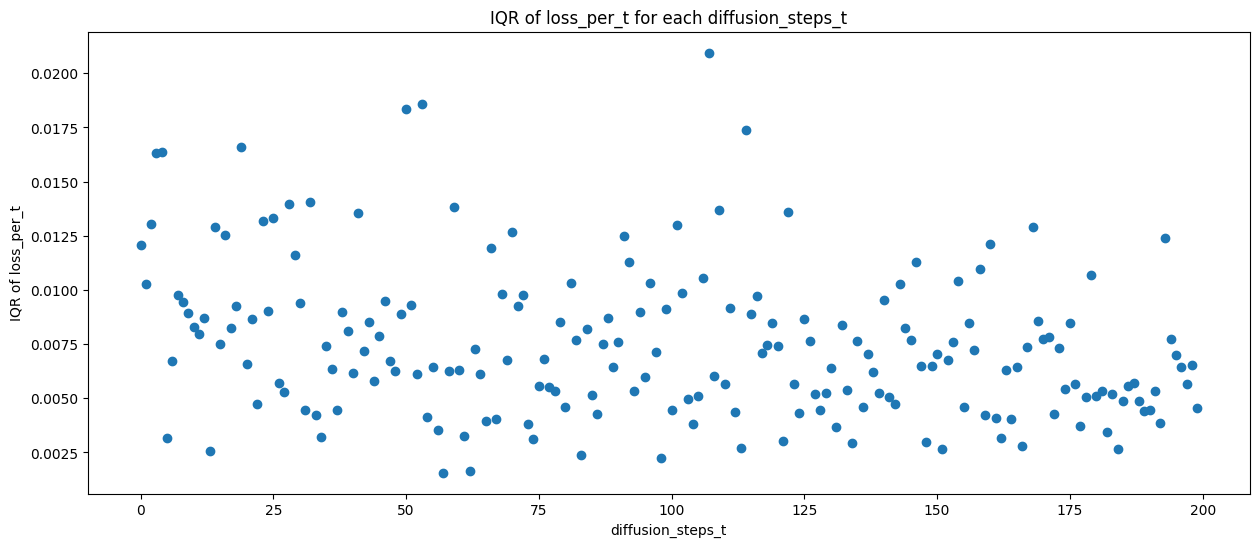

In [13]:
# Calculate the IQR for each diffusion_steps_t
df['IQR'] = df.groupby('diffusion_steps_t')['loss_per_t'].apply(lambda x: x.quantile(0.75) - x.quantile(0.25))

# Plot the IQR by diffusion_steps_t
plt.figure(figsize=(15, 6))
plt.scatter(df.index, df['IQR'])
plt.xlabel('diffusion_steps_t')
plt.ylabel('IQR of loss_per_t')
plt.title('IQR of loss_per_t for each diffusion_steps_t')
plt.grid(False)
plt.show()

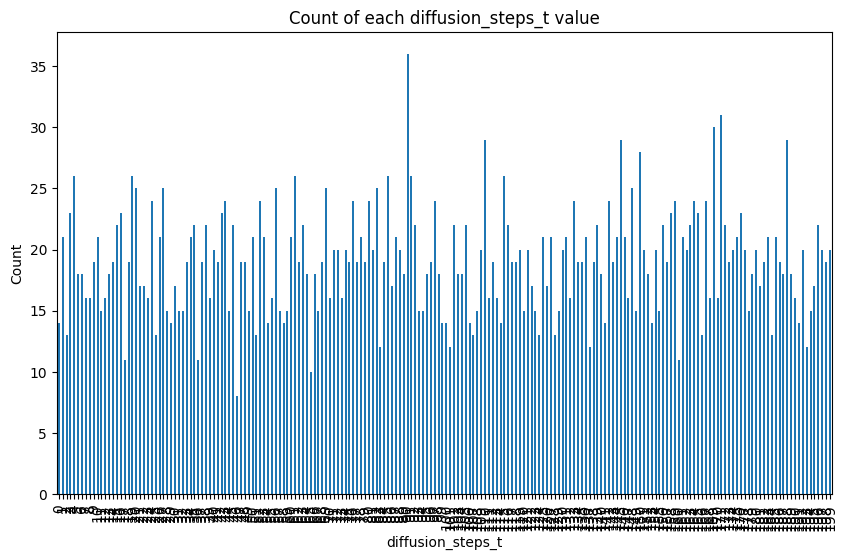

In [16]:
# Count the occurrences of each diffusion_steps_t value
counts = df['diffusion_steps_t'].value_counts()

# Create the plot
plt.figure(figsize=(10, 6))
counts.sort_index().plot(kind='bar')
plt.xlabel('diffusion_steps_t')
plt.ylabel('Count')
plt.title('Count of each diffusion_steps_t value')
plt.show()

In [15]:
import wandb

api = wandb.Api()

# Replace 'my_project' with your project name
runs = api.runs("ecg_SSSD_SSSDS4")

for run in runs:
    if 'good run' in run.tags:
        print(run.id)

ywwhgg9f


In [2]:
for epoch in range(1000):
    stat = 0
    for i in range(300):
        stat+=1
        
        if (i+1) % 100 == 0:
            print(f"{epoch=}, {i=}, {stat=}")
            stat = 0

epoch=0, i=99, stat=100
epoch=0, i=199, stat=100
epoch=0, i=299, stat=100
epoch=1, i=99, stat=100
epoch=1, i=199, stat=100
epoch=1, i=299, stat=100
epoch=2, i=99, stat=100
epoch=2, i=199, stat=100
epoch=2, i=299, stat=100
epoch=3, i=99, stat=100
epoch=3, i=199, stat=100
epoch=3, i=299, stat=100
epoch=4, i=99, stat=100
epoch=4, i=199, stat=100
epoch=4, i=299, stat=100
epoch=5, i=99, stat=100
epoch=5, i=199, stat=100
epoch=5, i=299, stat=100
epoch=6, i=99, stat=100
epoch=6, i=199, stat=100
epoch=6, i=299, stat=100
epoch=7, i=99, stat=100
epoch=7, i=199, stat=100
epoch=7, i=299, stat=100
epoch=8, i=99, stat=100
epoch=8, i=199, stat=100
epoch=8, i=299, stat=100
epoch=9, i=99, stat=100
epoch=9, i=199, stat=100
epoch=9, i=299, stat=100
epoch=10, i=99, stat=100
epoch=10, i=199, stat=100
epoch=10, i=299, stat=100
epoch=11, i=99, stat=100
epoch=11, i=199, stat=100
epoch=11, i=299, stat=100
epoch=12, i=99, stat=100
epoch=12, i=199, stat=100
epoch=12, i=299, stat=100
epoch=13, i=99, stat=100
epoc

In [55]:
split_pSignal_file = "/home/liranc6/data/with_R_beats/icentia11k-continuous-ecg_normal_sinus_subset_npArrays_splits/10minutes/train/p0_to_p32.h5"  # newton

def _get_statistics_for_normalization(filename):
    data_with_RR = True
    mean = 0
    std = 0
    max_val = np.NINF
    min_val = np.Inf
    with h5py.File(filename, 'r') as h5_file:
        keys = list(h5_file.keys())
        num_keys = len(keys)
        pbar_keys = tqdm(keys , total=num_keys)
        for i, key in enumerate(pbar_keys):
            pbar_keys.set_description(f"Reading {key}")
            if data_with_RR:
                data = h5_file[key][()][:, 0, :]
            else:
                data = h5_file[key][()]
            mean += np.mean(data, axis=0)
            std += np.std(data, axis=0)
            max_val = max(max_val, np.max(data))
            min_val = min(min_val, np.min(data))
            
            if i >=0:
                break
            
        mean /= num_keys
        std /= num_keys
        
    return {"mean": mean, "std": std, "max": max_val, "min": min_val}, data
    
norm_statistics, dataset = _get_statistics_for_normalization(split_pSignal_file)

Reading 00000:   0%|          | 0/32 [00:00<?, ?it/s]

Reading 00000:   0%|          | 0/32 [00:02<?, ?it/s]


In [70]:
def get_dataset_statistics(dataset):
    mean = np.mean(dataset, axis=0)
    std = np.std(dataset, axis=0)
    max_val = np.max(dataset)
    min_val = np.min(dataset)
    return {"mean": mean, "std": std, "max": max_val, "min": min_val}

def normalized(data, normalize_method, norm_statistic=None):
    if normalize_method == 'min_max':
        scale = norm_statistic['max'] - norm_statistic['min'] + 1e-5
        data = (data - norm_statistic['min']) / scale
    elif normalize_method == 'z_score':
        mean = norm_statistic['mean']
        std = norm_statistic['std']
        std = np.where(std == 0, 1, std)
        data = (data - mean) / std
    return data

def de_normalized(data, normalize_method, norm_statistic):
    if normalize_method == 'min_max':
        scale = norm_statistic['max'] - norm_statistic['min'] + 1e-8
        data = data * scale + norm_statistic['min']
    elif normalize_method == 'z_score':
        mean = norm_statistic['mean']
        std = norm_statistic['std']
        std = np.where(std == 0, 1, std)
        data = data * std + mean
    return data

In [76]:
dataset_stat = get_dataset_statistics(dataset)

data = normalized(dataset, 'min_max', norm_statistic=dataset_stat)

data_stat = get_dataset_statistics(data)

print(f"{dataset_stat=}")



dataset_stat={'mean': array([0.02618435, 0.02143934, 0.00106074, ..., 0.01057455, 0.01582309,
       0.0206558 ]), 'std': array([0.44777137, 0.39134066, 0.25881205, ..., 0.14827467, 0.15277812,
       0.15810779]), 'max': 2.164643619685852, 'min': -4.2089793084505756}


In [77]:
data = de_normalized(data, 'min_max', norm_statistic=dataset_stat)

data_stat = get_dataset_statistics(data)

print(f"{data_stat=}")

data_stat={'mean': array([0.02617772, 0.02143271, 0.00105414, ..., 0.01056793, 0.01581647,
       0.02064917]), 'std': array([0.44777067, 0.39134005, 0.25881165, ..., 0.14827444, 0.15277788,
       0.15810754]), 'max': 2.164633629701526, 'min': -4.2089793084505756}


In [78]:
2.164643619685852- 2.164633629701526

9.989984325997625e-06

In [80]:
1 * 60 * 250

15000

In [10]:
!gpustat

chuck1                    Sat Oct  5 01:58:46 2024  535.161.08
[0] NVIDIA A100-SXM4-80GB | 21°C,   0 % | 18920 / 81920 MB | liranc6(18912M)


In [2]:
import subprocess

# Get the current Git commit ID
commit_id = subprocess.check_output(["git", "rev-parse", "HEAD"]).strip().decode('utf-8')
commit_id

'58d9ad0d484e7f50897d8bcd977d760c71e0c9c6'

In [1]:
import wandb
from unittest.mock import MagicMock, patch
import math

# Initialize the first run and log some metrics
# Replace with your_project_name and your_entity_name!
run1 = wandb.init(project="your_project_name", entity="your_entity_name", mode="offline")
for i in range(300):
    run1.log({"metric": i})
    
print(f"First run ID: {run1.id}")
run1.finish()


# Rewind from the first run at a specific step and log the metric starting from step 200
configs = {
            # "project" : "your_project_name", 
            # "entity" : "your_entity_name", 
            "resume_from": f"{run1.id}?_step=200",
            "mode": "offline"
            }


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


First run ID: 4sox3geb


metric,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
metric,299


In [3]:

run2 = wandb.init(resume_from=f"{run1.id}?_step=200", mode= "offline")

# Continue logging in the new run
# For the first few steps, log the metric as is from run1
# After step 250, start logging the spikey pattern
for i in range(200, 300):
    if i < 250:
        run2.log({"metric": i, "step": i})  # Continue logging from run1 without spikes
    else:
        # Introduce the spikey behavior starting from step 250
        subtle_spike = i + (2 * math.sin(i / 3.0))  # Apply a subtle spikey pattern
        run2.log({"metric": subtle_spike, "step": i})
    # Additionally log the new metric at all steps
    run2.log({"additional_metric": i * 1.1, "step": i})
run2.finish()

TypeError: init() got an unexpected keyword argument 'resume_from'

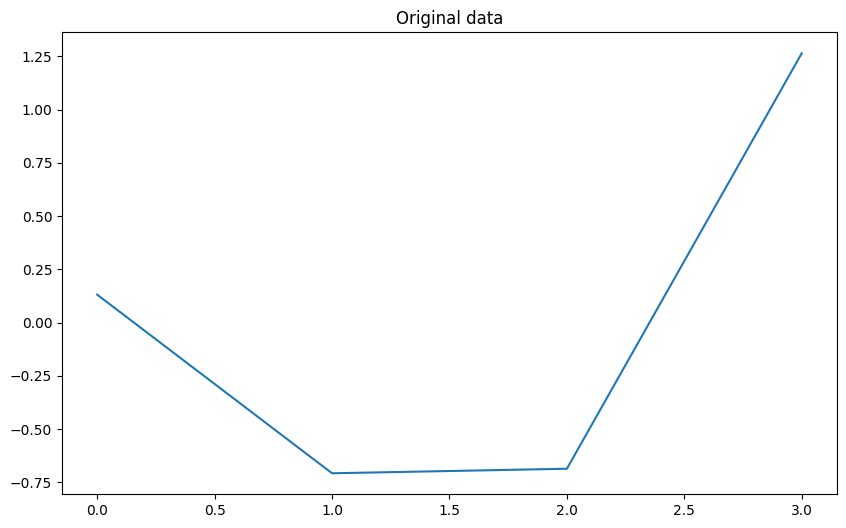

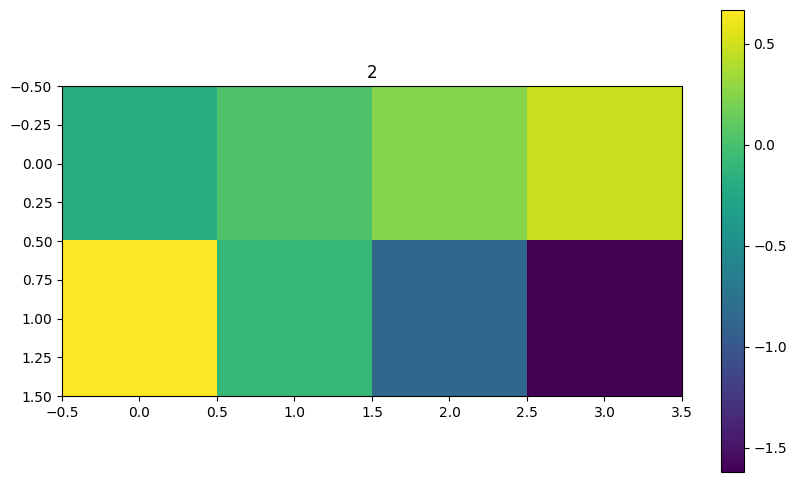

In [9]:
def visualize_signal(tensor, title=""):
    plt.figure(figsize=(10, 6))
    plt.plot(tensor)
    plt.title(title)
    plt.show()

origin_sognal = torch.tensor([[ 0.1315],
                                [-0.7071],
                                [-0.6858],
                                [ 1.2648]])

visualize_signal(origin_sognal, "Original data")

batch_x_trend = torch.tensor([[[-0.1997],
                                [ 0.0270],
                                [ 0.2536],
                                [ 0.4803]],

                                [[ 0.6673],
                                [-0.0949],
                                [-0.8571],
                                [-1.6193]]])

visualize_tensor(batch_x_trend, "2")

In [18]:
import torch
x = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(f"{x.shape=}")

class moving_avg(nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x
    
output = moving_avg(3, 1)(x)
print(f"{output.shape=}")

x.shape=torch.Size([3, 3])


IndexError: too many indices for tensor of dimension 2

In [1]:
import os

filename = "/home/liranc6/ecg_forecasting/liran_project/results/icentia11k/mrDiff/DDPM_icentia11k_ftS_sl105000_ll7500_pl7500_lr0.001_bs16_invFalse_itr0/21_10_2024_1424/logs/1_last_checkpoint.pth"

# Extract the part '21_10_2024_1424'
extracted_part = os.path.basename(os.path.dirname(os.path.dirname(filename)))

print(extracted_part)

21_10_2024_1424
